# A softmax regressor for topic classification

We will build a softmax regressor that performs  topic classification. It will be trained with sentences belonging to different topics and then evaluated to classifiy new sentences. As the softmax regressor expects a single vector (or a batch of vectors) as input, we will transform every sentence into an embedding vector. You probably don't know how to perform this transformation yet, so for now we will rely on a library that performs the task for us. 

Unlike the notebook on the logistic regressor, here we will use PyTorch functions to build the model and train it, instead of relying on a low level implementation which will be harder and harder to maintain as we build more complex models. But first, let's proceed with module installation.

In [15]:
!pip install torch transformers sentence_transformers


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Obtaining the data

The library that performs the transformation of a sentence into a vector (embedding) is called `sentence_transformers`. It can work with a number of different models available on the HuggingFace hub. Each model has specific feature such as number of parameters, size of the resulting embeddings, supported languages, etc. The particular model is not relevant for our objectives here, so let's use one of the smallest (and fastest) called [gte-small](https://huggingface.co/thenlper/gte-small). It works for English and returns sentence embeddings of size 384. See it in action in the following code outputing embeddings for two sentences. These embeddings have some interesting properties; for example, two sentences with similar meanings will produce *similar* embeddings. In natural language processing we will measure this similarity with metrics such as the *cosine similarity* or a less compute-intensive alternative such as the *dot product* (also called scalar product). We could do `print(embeddings[0])` to print the whole tensor, but it would print a lot of values (actually, 384), so let's print the first 3 values as a subtensor so that you can see that sentences have been transformed into a bunch of numbers. Don't worry too much about the particular values of the cosine similarity (they are values between -1 and 1); just focus on the fact that similar sentences will have closer embeddings and cosine similarities closer to 1.

Documentation: [sentence_transformers.SentenceTransformer.encode](https://www.sbert.net/docs/package_reference/SentenceTransformer.html#sentence_transformers.SentenceTransformer.encode)

In [18]:
from sentence_transformers import SentenceTransformer
import torch

sentences = ['That is a happy person', 'That is a very happy person', 'That is a sad person', 'My drawing was not a picture of a hat']

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model_embedding = SentenceTransformer('thenlper/gte-small', device=device)
embeddings = model_embedding.encode(sentences, convert_to_tensor=True)

print(f"embeddings.shape={embeddings.shape}")
print(f"embeddings[0][:3]={embeddings[0][:3]}")  # first 3 dimensions of the first sentence

cos = nn.CosineSimilarity(dim=0) # works on dim=1 by default (a batch of tensors, but there is only dim=0 in our case)

print(f"Cosine similarity between '{sentences[0]}' and '{sentences[1]}' is {cos(embeddings[0], embeddings[1]).item():.3f}")
print(f"Cosine similarity between '{sentences[0]}' and '{sentences[2]}' is {cos(embeddings[0], embeddings[2]).item():.3f}")
print(f"Cosine similarity between '{sentences[0]}' and '{sentences[3]}' is {cos(embeddings[0], embeddings[3]).item():.3f}")

Using device: cpu
embeddings.shape=torch.Size([4, 384])
embeddings[0][:3]=tensor([-0.0532,  0.0104,  0.0619])
Cosine similarity between 'That is a happy person' and 'That is a very happy person' is 0.982
Cosine similarity between 'That is a happy person' and 'That is a sad person' is 0.898
Cosine similarity between 'That is a happy person' and 'My drawing was not a picture of a hat' is 0.752


After seeing an example of how to use the `sentence_transformers` library to transform sentences into embeddings, let's proceed with the preparation of the data. As our objective is not to train a real useful system but to learn how to use PyTorch, we will use an extremely tiny dataset comprised of a few sentences belonging to 3 different topics.

We use `sentence_transformers.SentenceTransformer.encode` in order to transform the train and test sentences into embeddings. The results are PyTorch tensors, so we can use them directly in our PyTorch model.

In [24]:
sentences_train = [
    # politics:
    'The election results were surprising',
    'The new policy on healthcare was announced',
    'The government passed a new education reform',
    # sports:
    'The soccer team won the championship',
    'The Olympics will be held next year',
    'She won the gold medal in swimming',
    # culture:
    'The museum exhibited contemporary art',
    'The film festival was a huge success',
    'The concert was sold out'
]

labels_train = [0, 0, 0, 1, 1, 1, 2, 2, 2]  # 0: politics, 1: sports, 2: culture

sentences_test = [
    'A new law was proposed',
    'The basketball game was exciting',
    'The opera was a beautiful experience'
]

labels_test = [0, 1, 2]

embeddings_train = model_embedding.encode(sentences_train, convert_to_tensor=True)
embeddings_test = model_embedding.encode(sentences_test, convert_to_tensor=True)
labels_train = torch.tensor(labels_train).to(device)
labels_test = torch.tensor(labels_test).to(device)

print(f"type(embeddings_train)={type(embeddings_train)}")
print(f"embeddings_train.shape={embeddings_train.shape}")
print(f"embeddings_train[0][:3]={embeddings_train[0][:3]}")


type(embeddings_train)=<class 'torch.Tensor'>
embeddings_train.shape=torch.Size([9, 384])
embeddings_train[0][:3]=tensor([-0.0382,  0.0470,  0.0139])


## Model definition

To define our model we define a class that inherits from `torch.nn.Module`. We define the layers and parameters of the model in the constructor (`__init__`) and the forward pass in the `forward` method. The forward pass is the method that will be called to obtain the output of a model given an input. In our case, the input will be a mini-batch of sentence embeddings and the output will be a vector of size 3 (one value for each topic). The softmax function will then be applied to the output vector to obtain a probability distribution over the 3 topics.

In the code, we define a class `SoftmaxRegressor`, which extends `torch.nn.Module`, the fundamental building block for neural networks in PyTorch. The `__init__` method initializes this class with two parameters: `input_size` (size of the input features without the batch dimension) and `num_classes` (number of output classes for classification). The call to `super().__init__()` within this method is essential as it initializes the parent class, which implements most of the functionality of our model. A linear layer is created using `torch.nn.Linear` which applies a linear transformation to the incoming data. This linear layer is essentially a matrix of weights that gets multiplied with the input features, followed by the addition of a bias term. This assumes a first dimension corresponding to the batch size, so the input features are expected to be of size `(batch_size, input_size)`. The output of the linear layer will be of size `(batch_size, num_classes)`.

The `forward` method outlines the forward pass of the neural network. Here, the output of the linear layer is passed through the `torch.nn.functional.log_softmax` function. This function applies a softmax activation followed by a logarithm, producing the logarithmic probabilities of the classes. The `dim=1` argument in `log_softmax` specifies that the softmax should be applied across the columns, calculating the softmax for each row in the batch. The `log_softmax` function is used instead of the `softmax` function because it is numerically more stable. Remember the fundamental concepts here: the constructor defines the layers and parameters of the model, and the forward pass defines how the input is transformed into the output.

Documentation: [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), [torch.nn.functional.log_softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.log_softmax.html)

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class SoftmaxRegressor(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, X):
        return F.log_softmax(self.linear(X), dim=1)

## Model instantiation

When training our model, our recipe will contain three fundamental ingredients: the model, the loss function, and the optimizer. A fourth one is the learning rate scheduler, which is not used in this example. The scheduler adjusts the learning rate during training, usually rising it at the beginning and then reducing it as the training progresses. This way, model's convergence is more easily achieved.

In the code, we start by creating an instance of our model and moving it to the device where we will perform the computations. The object `criterion` of class `torch.nn.NLLLoss` does not only set up the loss function, but also contains the logic to compute the derivative of the loss function with respect to the model parameters. The `optimizer` object of class `torch.optim.SGD` implements the stochastic gradient descent algorithm, which is used to update the model parameters during training based on the gradient of the loss function. The function `torch.nn.Module.parameters` inherited by our model returns an iterator over the model parameters (weights and biases of the linear layer in our case). There are more advanced optimizers available in PyTorch, but we will stick to the basic one for now.

In PyTorch, `torch.nn.CrossEntropyLoss`, `torch.nn.BCELoss`, and `torch.nn.NLLLoss` are loss functions used in different classification contexts, each with specific requirements for their input types. `CrossEntropyLoss` is widely used for multi-class classification tasks and is designed to take *logits* (the raw, unnormalized scores outputted by the final layer of the network) as its inputs. Significantly, `CrossEntropyLoss` does not require the target labels to be one-hot encoded; it expects them to be class indices. Internally, this function applies the softmax function to the logits and then computes the log loss. In binary classification scenarios, `BCELoss` (binary cross-entropy loss) is the go-to choice. This function expects the outputs of your model to be probabilities; the target labels for `BCELoss` should be in the same format as the model outputs, i.e., probabilities, not indices. Finally, `NLLLoss` (negative log likelihood loss), is used in multi-class classification tasks, and expects log-probabilities in the output, which requires applying a `log_softmax` function to your model's final layer outputs. The target labels for `NLLLoss` should also be class indices, not one-hot encoded vectors. In summary, `CrossEntropyLoss` and `NLLLoss` are used for multi-class classification and expect class indices as targets, while `BCELoss` is for binary classification and expects probabilities.

Documentation: [torch.nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html), [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)

In [26]:
input_size = embeddings_train.size(1)  # input embedding size
num_classes = 3  # number of topics
learning_rate = 0.001

model = SoftmaxRegressor(input_size, num_classes)
model.to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


## Training

The training loop is similar to the one you studied in the previous notebook, but here we delegate in PyTorch the computation of the gradients and the update of the model parameters.

Notice how the code seems to call `model` and `criterion` which have been defined as objects before and not functions. This is possible because these classes implement the `__call__` method, which allows them to be called as if they were functions. Python allows the programmer to define a number of these *dunder* (for double underscores) magic methods. In this case, `__call__` is defined in `nn.Module` and calls the overriden `forward` method in the child class (our `SoftmaxRegressor` class in this case).

The function `torch.Tensor.backward` computes the gradient of the loss with respect to the model parameters. The function `torch.optim.Optimizer.step` updates the model parameters based on the computed gradients. The function `torch.optim.Optimizer.zero_grad` clears the gradients of all optimized parameters. This is not done automatically by PyTorch because we might want to accumulate gradients from multiple batches before updating the parameters; this way, we can emulate epoch-based training by accumulating gradients from all batches and then updating the parameters.

Regarding the call to `torch.nn.Module.train`, this is not strictly necessary in our case, but it is good practice to call it before training. This function sets the model in training mode, which is important for some layers such as `Dropout` and `BatchNorm` which behave differently during training and evaluation. Alternatively, the function `torch.nn.Module.eval` sets the model in evaluation mode as we will see later.

Documentation: [torch.optim.Optimizer.zero_grad](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html), [torch.Tensor.backward](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html), [torch.optim.Optimizer.step](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html)

**Exercise**: modify the code so that each mini-batch contains a single sentence embedding instead of a batch of embeddings. Display the loss evolution during training and compare it to the epoch-based training. What do you observe? Why?

Step [10000/100000], loss: 0.3989
Step [20000/100000], loss: 0.3453
Step [30000/100000], loss: 0.3029
Step [40000/100000], loss: 0.2687
Step [50000/100000], loss: 0.2407
Step [60000/100000], loss: 0.2175
Step [70000/100000], loss: 0.1981
Step [80000/100000], loss: 0.1816
Step [90000/100000], loss: 0.1674
Step [100000/100000], loss: 0.1551


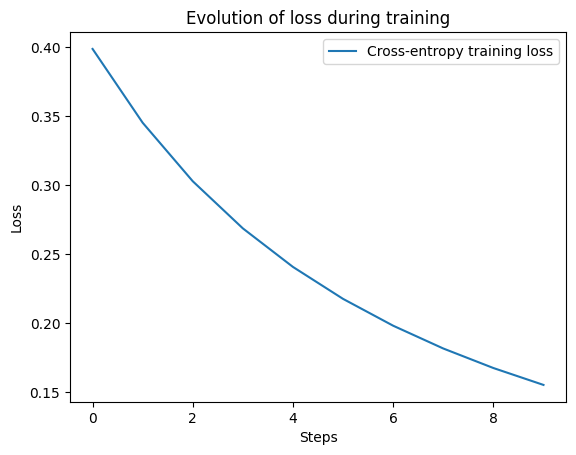

In [34]:
training_steps = 100000
eval_steps = 10000

model.train()
losses = []
for step in range(training_steps):
    outputs = model(embeddings_train)
    loss = criterion(outputs, labels_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (step+1) % eval_steps == 0:
        print(f'Step [{step+1}/{training_steps}], loss: {loss.item():.4f}')
        losses.append(loss.item())

import matplotlib.pyplot as plt

# Plot training loss:
plt.plot(losses, label='Cross-entropy training loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Evolution of loss during training')
plt.legend()
plt.show()


## Evaluation

When computing accuracy over a test set in PyTorch, using `with torch.no_grad()` is a good practice for optimizing performance. The primary function of `no_grad` is to disable gradient tracking, which is essential during the training phase but unnecessary during inference or evaluation. By turning off gradient computation, memory usage is reduced and computations accelerated. Within the `with torch.no_grad()` context, the result of every operation will have `requires_grad=False`, meaning that the PyTorch autograd engine will not track these operations for gradient calculation. It is important to note that `no_grad` is orthogonal to the `eval` and `train` methods; while `eval` sets the model to evaluation mode (affecting layers like dropout and batch normalization), `no_grad` is specifically focused on disabling gradient computation.


In [38]:
model.eval()
with torch.no_grad():
    correct = 0
    total = len(embeddings_test)
    outputs = model(embeddings_test)
    print(f'outputs={outputs}')
    _, predicted = torch.max(outputs, dim=1)
    print(f'predicted={predicted}')
    correct += (predicted == labels_test).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy on test data: {accuracy:.2f}%')

outputs=tensor([[-0.4223, -1.5581, -2.0105],
        [-1.4214, -0.7079, -1.3244],
        [-1.8425, -1.6497, -0.4316]])
predicted=tensor([0, 1, 2])
Accuracy on test data: 100.00%


## Model saving and loading

The function `torch.save` saves the model parameters to a file. The function `torch.load` loads the model parameters from a file. The file extension is usually `.pt` or `.pth`. There are two possibilities for model saving depending on whether we want to continue training the model or not. During training, a large amount of information beyond the model parameters may be stored by, for example, the optimizer. If we want to continue training the model from the current point, all these must be saved too with `torch.save(model, path)`. If we just want to redistribute the model for inference, we can save only the model parameters with `torch.save` as in the following code.


In [39]:
torch.save(model.state_dict(), 'model.pth')
loaded_model = SoftmaxRegressor(input_size, num_classes)
loaded_model.load_state_dict(torch.load('model.pth'))
loaded_model.eval()

SoftmaxRegressor(
  (linear): Linear(in_features=384, out_features=3, bias=True)
)